# Network Analysis

# Imports

In [3]:
import pandas as pd
import seaborn as sns

import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

from util import generate_type_graph
import os

# Data Acquisition

In [4]:
graph_dump_file = "team_ip_1.gml"
if not os.path.exists(graph_dump_file):
    g = generate_graph(db_host='http://localhost:8529', db_name='real_wo_external_values', username='root',
                      password='98G%nG^Xu5Bek4')
    nx.write_gml(g, graph_dump_file)
else:
    g = nx.read_gml(graph_dump_file)

In [5]:
nodes = np.random.permutation(g.nodes)
node_types = pd.Series(nx.get_node_attributes(g, 'type'))#.fillna('UNK')
enough_samples = node_types.value_counts() > 100
primitive_types = ['pmString', 'pmLabel', 'pmDate', 'pmNumber', 'pmDateTime']

is_relevant = node_types.map(enough_samples) & (node_types != 'UNK') & ~node_types.isin(primitive_types)
relevant_nodes = node_types.index[is_relevant]
y = node_types

# Data Analysis

## Basic Statistics

In [6]:
print(g.number_of_nodes(), 'nodes')
print(g.number_of_edges(), 'eges')
print(len(set(list(nx.get_edge_attributes(g, 'kind').values()))), 'edge types')
print(len(set(list(nx.get_node_attributes(g, 'type').values()))), 'node types')
print('density:', nx.density(g))

68846 nodes
160452 eges
1 edge types
124 node types
density: 3.385275499347916e-05


### Comparison

In [7]:
from dgl.data import CoraGraphDataset, KarateClubDataset

print('Cora density:', nx.density(CoraGraphDataset()[0].to_networkx()))
print('KarateClub density:', nx.density(KarateClubDataset()[0].to_networkx()))

Using backend: pytorch


Loading from cache failed, re-processing.
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
Cora density: 0.0014399999126942077
KarateClub density: 0.13903743315508021


## Node Types

'124 classes'

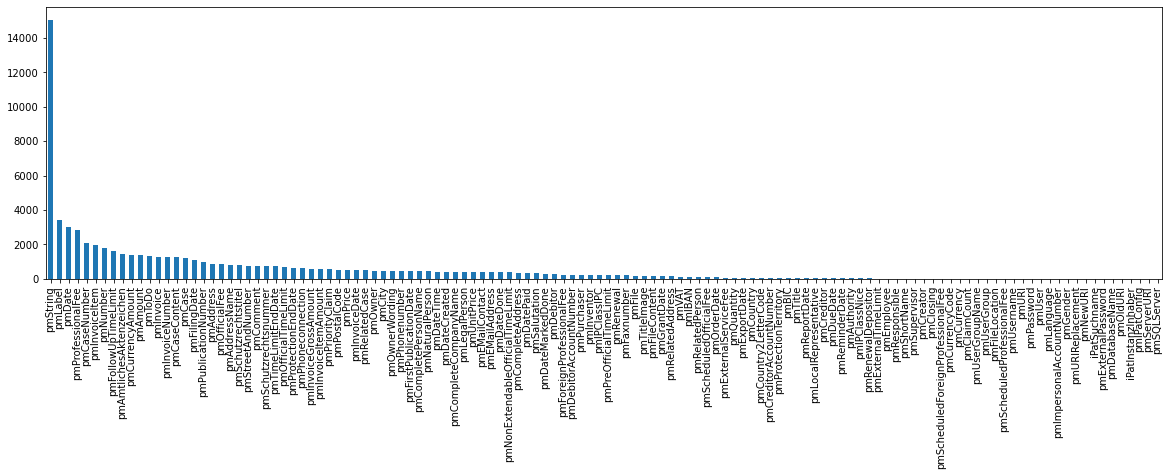

In [8]:
plt.figure(figsize=(20, 5))
y.value_counts().plot(kind='bar');
'{} classes'.format(len(y.unique()))

## Central Nodes

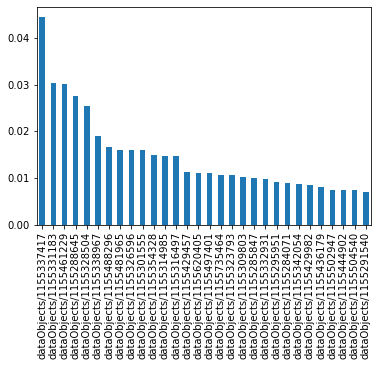

In [9]:
pd.Series(nx.in_degree_centrality(g)).sort_values(ascending=False)[:30].plot(kind='bar');

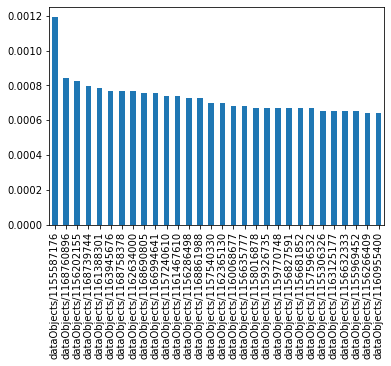

In [10]:
pd.Series(nx.out_degree_centrality(g)).sort_values(ascending=False)[:30].plot(kind='bar');

## Type Graph

In [11]:
type_graph = generate_type_graph(g)
type_graph = nx.relabel_nodes(type_graph, lambda n : n.replace('pm', ''))

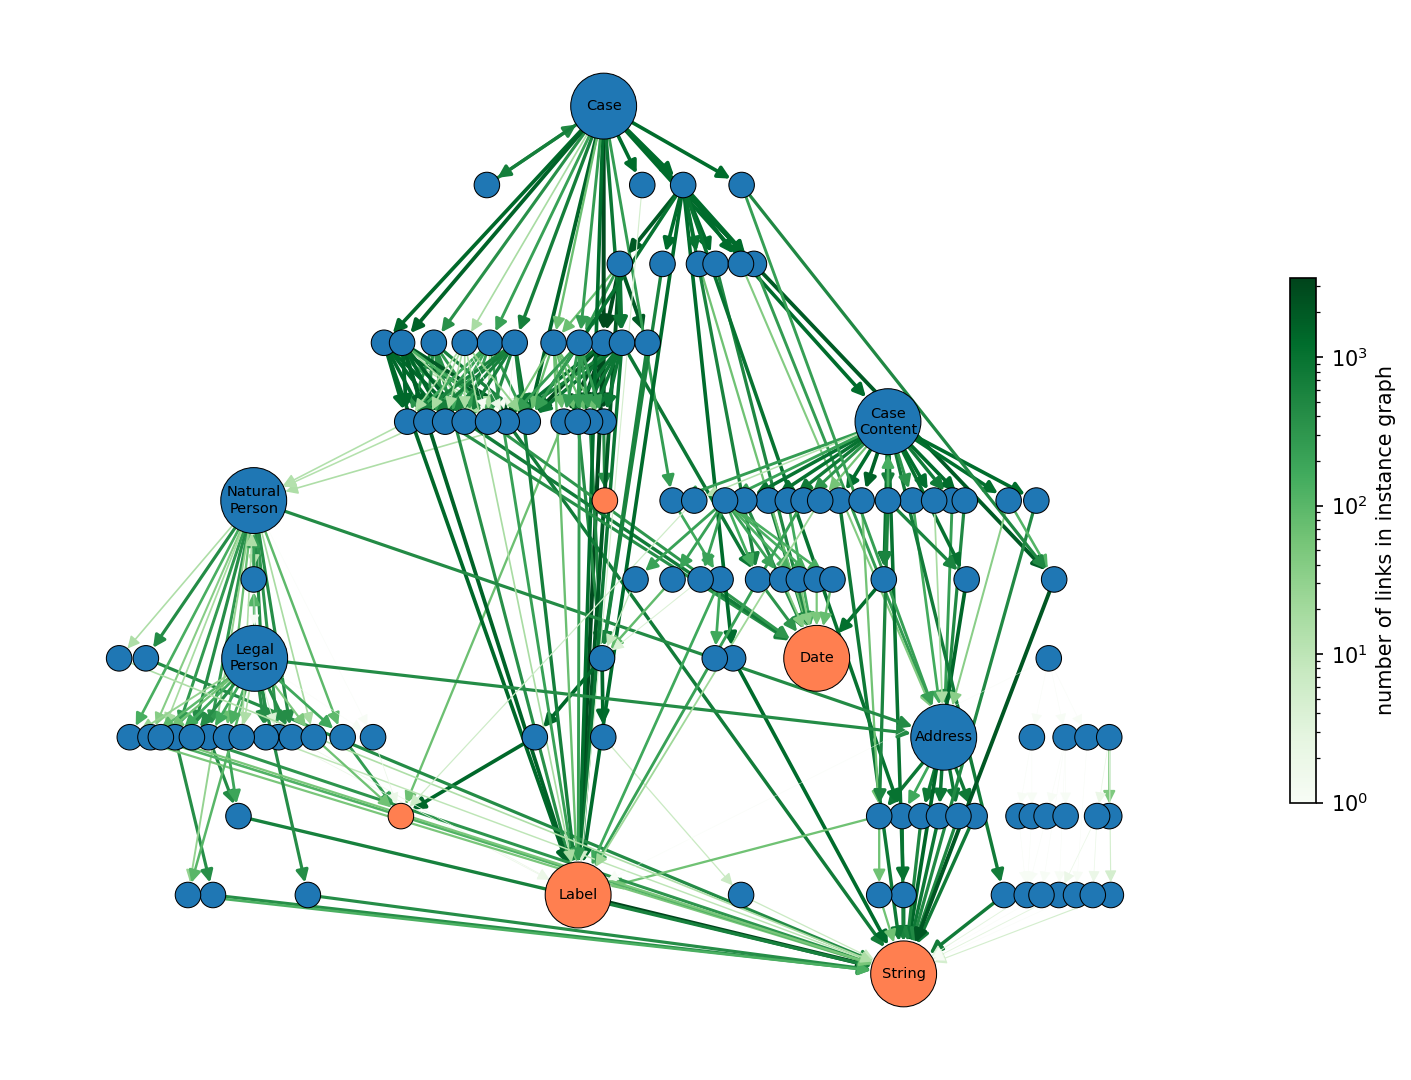

In [12]:
from matplotlib import cm, colors
import re
plt.figure(figsize=(10, 7), dpi=150)

weights = np.array([type_graph[u][v]['weight'] for u,v in type_graph.edges])
scaled_weights = 0.5 * np.log10(weights) + .2
centralities, thresh = nx.degree_centrality(type_graph), .11
node_labels = {n: '\n'.join(re.findall('[A-Z][^A-Z]*', n)) if centralities[n] > thresh else '' for n in type_graph}
node_sizes = [1000 if centralities[n] > thresh else 150 for n in type_graph]
node_colors = ['coral' if 'pm'+n in primitive_types else 'tab:blue' for n in type_graph]

nx.draw(type_graph, labels=node_labels, width=scaled_weights, node_size=node_sizes, edge_color = scaled_weights,
        pos=nx.nx_pydot.graphviz_layout(type_graph, prog='dot'), arrowsize=12, node_color=node_colors,
       edge_cmap=cm.Greens, linewidths=.5, font_size=7)

plt.gca().collections[0].set_edgecolor("k")

sm = plt.cm.ScalarMappable(cmap='Greens', norm=colors.LogNorm(vmin = np.min(weights), vmax=np.max(weights)))
plt.colorbar(sm, shrink=0.5, label='number of links in instance graph');

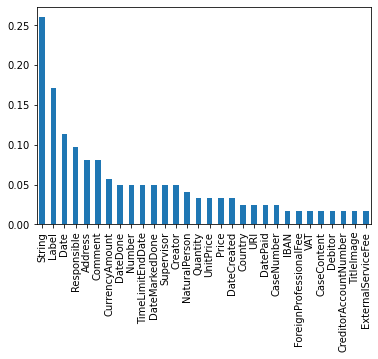

In [13]:
pd.Series(nx.in_degree_centrality(type_graph)).sort_values(ascending=False)[:30].plot(kind='bar');

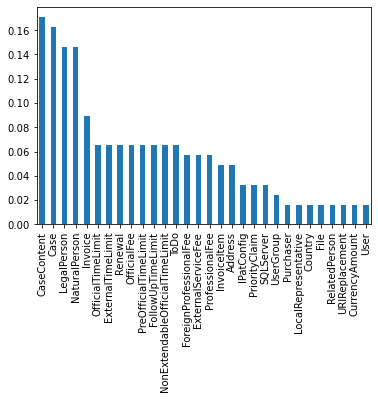

In [14]:
pd.Series(nx.out_degree_centrality(type_graph)).sort_values(ascending=False)[:30].plot(kind='bar');